In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

plt.style.use("ggplot")

In [2]:
# Original and output data folders + images folder
original = Path("../original/")
output = Path("../output/")
images = Path("../images/")

In [3]:
# Import saved data
MilkMeasurements = pd.read_csv(output / "MilkMeasurementsPlusGroupedTarget.csv")

In [4]:
# Combine breed and species information
MilkMeasurements["Breed"] = MilkMeasurements.apply(lambda row: f"{row['Breed']} ({row['Species']})", axis=1)

# Data recording period

In [5]:
# Cast date to correct type
MilkMeasurements["SampleDate"] = MilkMeasurements["SampleDate"].astype("datetime64[D]")

# Convert farm name to string to avoid scaling in figure axis
MilkMeasurements["ManagementAreaId"] = MilkMeasurements["ManagementAreaId"].astype(str)

In [6]:
# Get start and end dates of recording milk measurements for each farm
MilkMeasurementsMinMaxDates = (
    MilkMeasurements.groupby("ManagementAreaId")
    .agg(
        SampleDateMin=("SampleDate", "min"),
        SampleDateMax=("SampleDate", "max"),
        SamplesCount=("SampleDate", "size"),
        Breed=("Breed", set),
    )
    .reset_index()
)

# Compute date difference in days
MilkMeasurementsMinMaxDates["DateDiff"] = (
    MilkMeasurementsMinMaxDates["SampleDateMax"]
    - MilkMeasurementsMinMaxDates["SampleDateMin"]
)

In [7]:
# Map breed labels to IDs
breed_mapping = {
    "Florida (Goat)": 0,
    "Malagueña (Goat)": 1,
    "Murciano-granadina (Goat)": 2,
    "Payoya (Goat)": 3,
    "Assaf (Sheep)": 4,
    "Frisona (Cow)": 5,
}
MilkMeasurements["Breed"] = MilkMeasurements["Breed"].map(breed_mapping)

# Breed inverse mapping dictionary
breed_mapping_inverse = {int_label: breed_name for (breed_name, int_label) in breed_mapping.items()}

# Sort values according to breed
MilkMeasurements.sort_values("Breed", inplace=True)

# Get species and breed count per farm
animal_cols = ["Species", "Breed"]

AnimalCountPerFarm = (
    MilkMeasurements[["ManagementAreaId"] + animal_cols]
    .drop_duplicates()
    .groupby(animal_cols)
    .size()
    .reset_index()
    .rename(columns={0: "NumberOfFarms"})
    .sort_values("Breed")
)

# Map back breed IDs to labels
AnimalCountPerFarm["Breed"] = AnimalCountPerFarm["Breed"].map(breed_mapping_inverse)
MilkMeasurements["Breed"] = MilkMeasurements["Breed"].map(breed_mapping_inverse)

# Save and display
AnimalCountPerFarm.to_csv(output / "AnimalCountPerFarm.csv", index=False)
AnimalCountPerFarm

,Species,Breed,NumberOfFarms
1,Goat,Florida (Goat),5
2,Goat,Malagueña (Goat),6
3,Goat,Murciano-granadina (Goat),3
4,Goat,Payoya (Goat),3
5,Sheep,Assaf (Sheep),1
0,Cow,Frisona (Cow),1


In [8]:
# Extract breed from the created set
MilkMeasurementsMinMaxDates["Breed"] = MilkMeasurementsMinMaxDates["Breed"].apply(lambda row: [*row][0])

# Map breed labels to IDs
MilkMeasurementsMinMaxDates["Breed"] = MilkMeasurementsMinMaxDates["Breed"].map(breed_mapping)

# Sort values
MilkMeasurementsMinMaxDates = MilkMeasurementsMinMaxDates.sort_values(
    ["Breed", "SamplesCount"], ascending=[True, False], ignore_index=True,
)

In [9]:
# Get maximum of data count per breed
breed_max_count = MilkMeasurementsMinMaxDates[MilkMeasurementsMinMaxDates["ManagementAreaId"].str.strip() != ""].groupby("Breed")["SamplesCount"].max()

# Map back breed IDs to labels
MilkMeasurementsMinMaxDates["Breed"] = MilkMeasurementsMinMaxDates["Breed"].map(breed_mapping_inverse)

# Overview
MilkMeasurementsMinMaxDates.head()

,ManagementAreaId,SampleDateMin,SampleDateMax,SamplesCount,Breed,DateDiff
0,1524,2022-03-25,2023-11-20,241,Florida (Goat),605 days
1,1908,2022-12-01,2023-11-08,185,Florida (Goat),342 days
2,1898,2022-10-20,2023-11-21,157,Florida (Goat),397 days
3,1909,2022-12-01,2023-11-08,117,Florida (Goat),342 days
4,1910,2023-03-06,2023-11-08,81,Florida (Goat),247 days


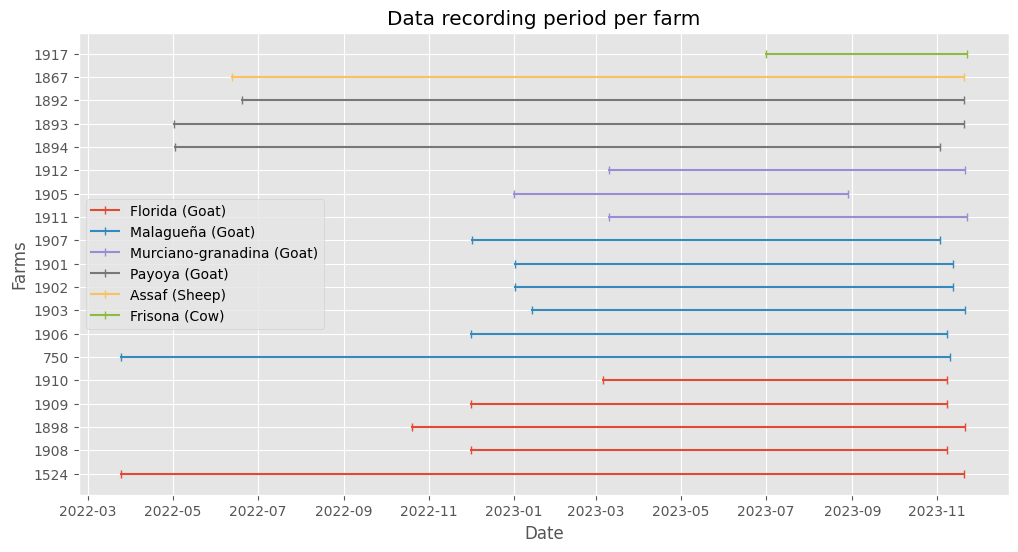

In [10]:
# Plot data recording period per farm
fig, ax = plt.subplots(figsize=(12, 6))

# Use a different color for each breed
ggplot_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Save breed once it's encountered to avoid duplicates in legend
breed_list = []

# Iterate over each row and plot the line for each ManagementAreaId
for index, row in MilkMeasurementsMinMaxDates.iterrows():
    # Get the breed
    breed = row["Breed"]
    
    # Plot the time periods
    plot, = ax.plot(
        [row["SampleDateMin"], row["SampleDateMax"]],
        [row["ManagementAreaId"], row["ManagementAreaId"]],
        marker="|",
        color=ggplot_colors[breed_mapping.get(breed)],
    )
    
    # Add label only if it doesn't exist
    if breed not in breed_list:
        plot.set_label(breed)
        breed_list.append(breed)

# Labels, title, legend, save and display
ax.set_xlabel("Date")
ax.set_ylabel("Farms")
title = "Data recording period per farm"
ax.set_title(title)
ax.legend()
plt.savefig(images / f"{title}.png")
plt.show()

# Number of samples per farm

In [11]:
# Insert blank rows for breed separation
separated_data = []
last_breed = None

# The farm names should not be the same for each blank inserted
# We're going to assign "i" blank spaces
i = 0
for _, row in MilkMeasurementsMinMaxDates.iterrows():
    # Add blank row after each breed
    if last_breed and last_breed != row["Breed"]:
        separated_data.append(
            pd.Series({
            "ManagementAreaId": " " * i,  # "i" blank spaces
            "SampleDateMin": pd.NaT,
            "SampleDateMax": pd.NaT,
            "SamplesCount": np.nan,
            "Breed": "",
            "DateDiff": pd.Timedelta(days=0),
            }, dtype="object")
        )
        i += 1
    
    # Add the current row
    separated_data.append(row)
    
    # Traceback the currect breed
    last_breed = row["Breed"]

MilkMeasurementsMinMaxDates = pd.DataFrame(separated_data)

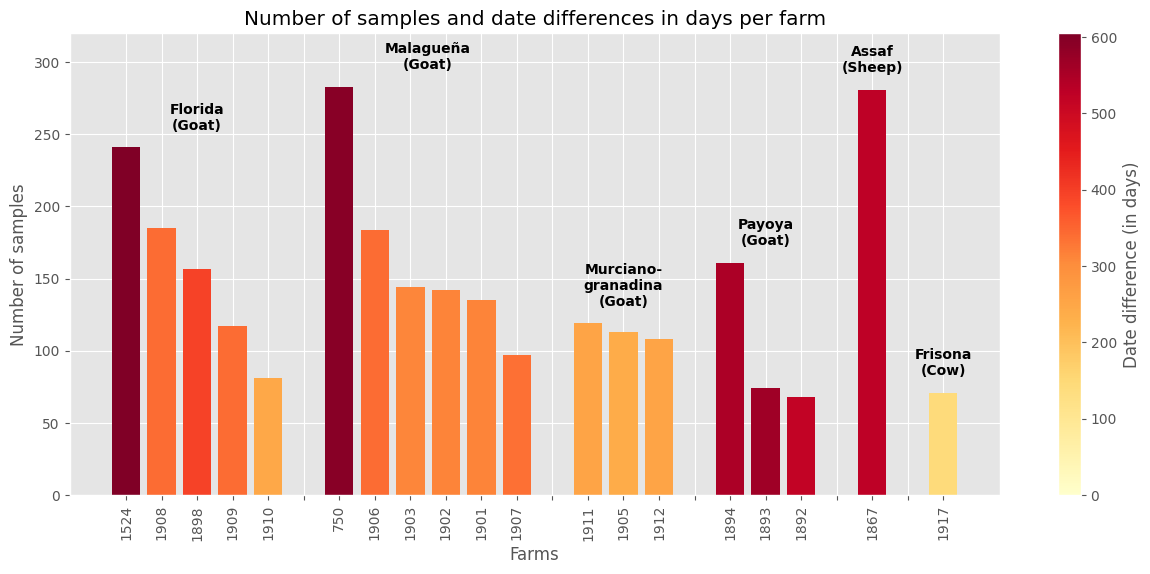

In [12]:
# Normalize DateDiff values to create a gradient color bar
norm = plt.Normalize(
    MilkMeasurementsMinMaxDates["DateDiff"].dt.days.min(),
    MilkMeasurementsMinMaxDates["DateDiff"].dt.days.max(),
)

# Define the colormap and colors
colors = cm.YlOrRd(norm(MilkMeasurementsMinMaxDates["DateDiff"].dt.days))

# Plot the bars
fig, ax = plt.subplots(figsize=(15, 6))
bars = ax.bar(
    MilkMeasurementsMinMaxDates["ManagementAreaId"],
    MilkMeasurementsMinMaxDates["SamplesCount"],
    color=colors,
)

# Labels, ticks, limits, and title
ax.set_xlabel("Farms")
plt.xticks(rotation=90)
ax.set_ylabel("Number of samples")
ax.set_ylim(0, 320)
title = "Number of samples and date differences in days per farm"
ax.set_title(title)

# Add the gradient color bar
sm = plt.cm.ScalarMappable(cmap=cm.YlOrRd, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Date difference (in days)")

# Format breed to add them on the plot
format_printed_breeds = lambda breed: breed.replace("-", "-\n").replace(" (", "\n(")

# Add breed names
i = 0
for (_, (_, breed, number_of_farms)), max_count in zip(AnimalCountPerFarm.iterrows(), breed_max_count):
    left_bar = bars[i]
    right_bar = bars[i+number_of_farms-1]
    i += number_of_farms + 1
    x = (left_bar.get_x() + right_bar.get_x() + right_bar.get_width()) / 2.0
    y = max_count + 10
    s = format_printed_breeds(breed)
    ax.text(x, y, s, fontweight="bold", ha="center", va="bottom")

# Save and display the plot
plt.savefig(images / f"{title}.png")
plt.show()

# Measurement distributions per farm, species and breed

In [13]:
# Sort data by animal breed and species
# MilkMeasurements.sort_values(["Species", "Breed"], inplace=True)

In [14]:
# The measurement ranges
MeasurementRange = pd.read_excel(original / "MeasurementRange.xlsx")

# Convert farm name to string to avoid scaling in figure axis
MeasurementRange["ManagementAreaId"] = MeasurementRange["ManagementAreaId"].astype(str)

In [15]:
# Milk characteristics labels in Spanish
MeasurementType = pd.read_excel(original / "MeasurementType.xlsx")

# Milk characteristics in English to match MilkMeasurements column names
MeasurementType["Measurement"] = [
    "Quantity",
    "EQ",
    "SomaticCellCount",
    "Fat",
    "Protein",
    "Bacteria",
    "Urea",
    "ES",
    "Casein",
    "Lactose",
    "FreezingPoint",
    "NumberOfAnimals",
]

# Drop quantity and number of animals because their values are unavailable, casein and lactose because they're unused in the recommandation algorithm
MeasurementType = MeasurementType[
    ~MeasurementType["Measurement"].isin(
        ["Quantity", "NumberOfAnimals", "Casein", "Lactose"]
    )
]

# Rename Id to MeasurementTypeId to match other tables' columns
MeasurementType.rename(columns={"Id": "MeasurementTypeId"}, inplace=True)

# Drop Spanish measurement names
MeasurementType.drop(columns="Name", inplace=True)

# Overview
MeasurementType

,MeasurementTypeId,Measurement
1,2,EQ
2,3,SomaticCellCount
3,4,Fat
4,5,Protein
5,6,Bacteria
6,7,Urea
7,8,ES
10,11,FreezingPoint


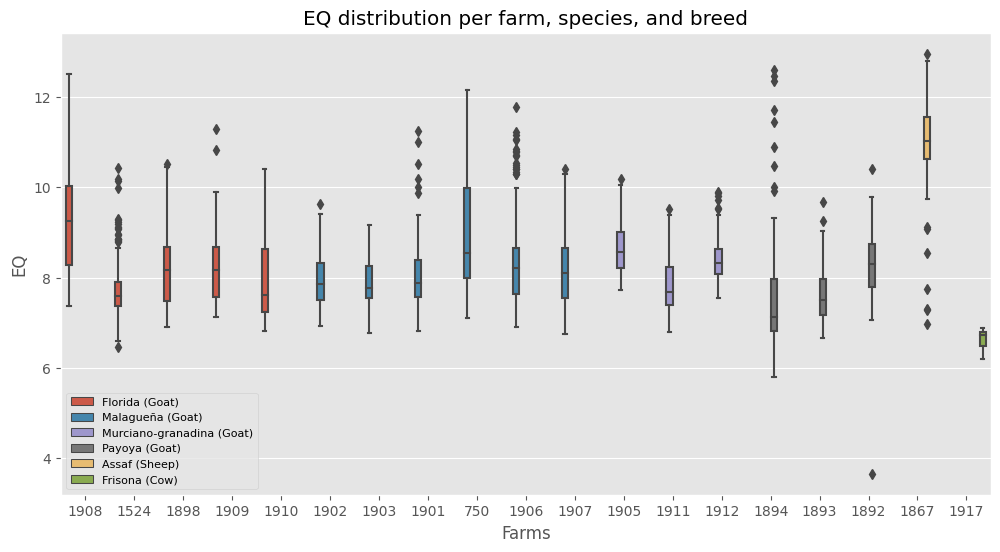

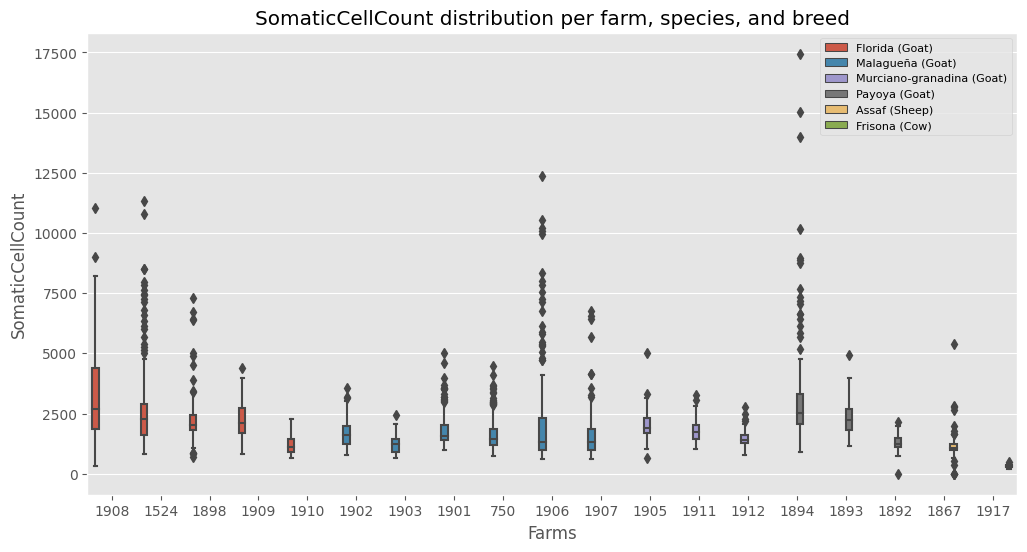

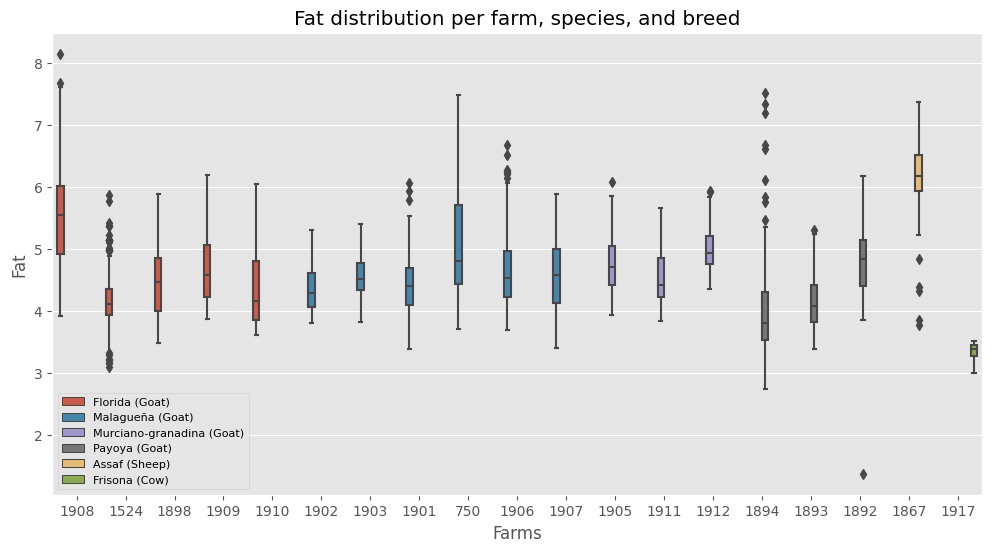

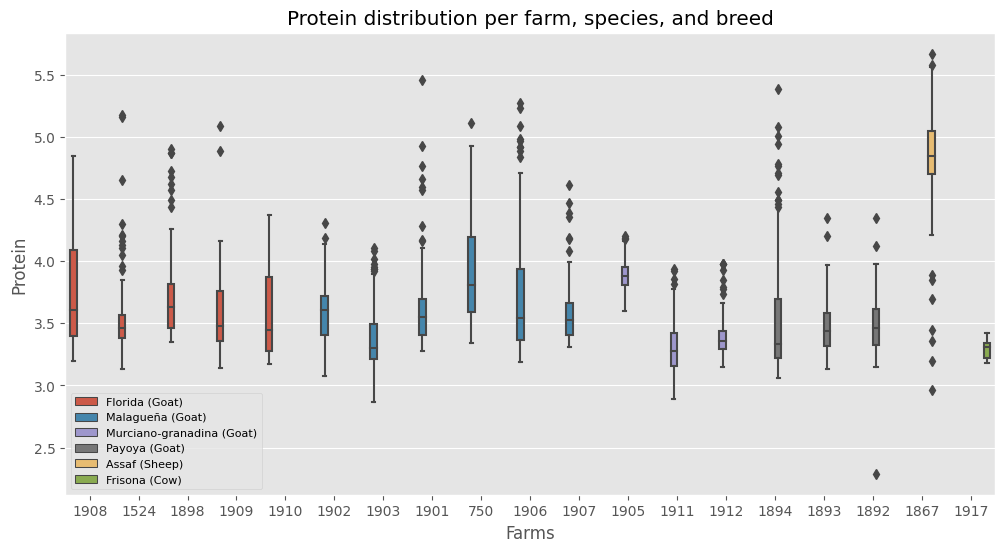

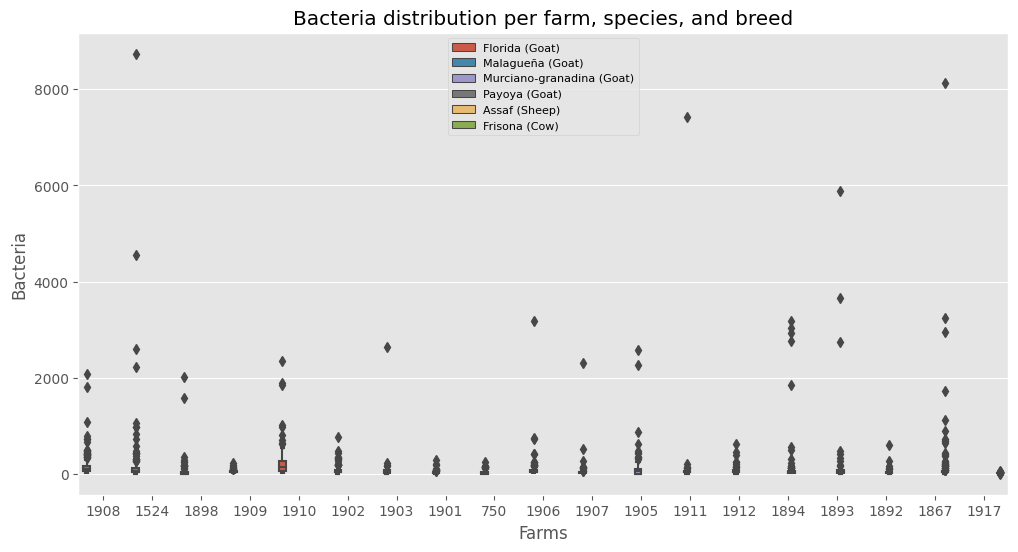

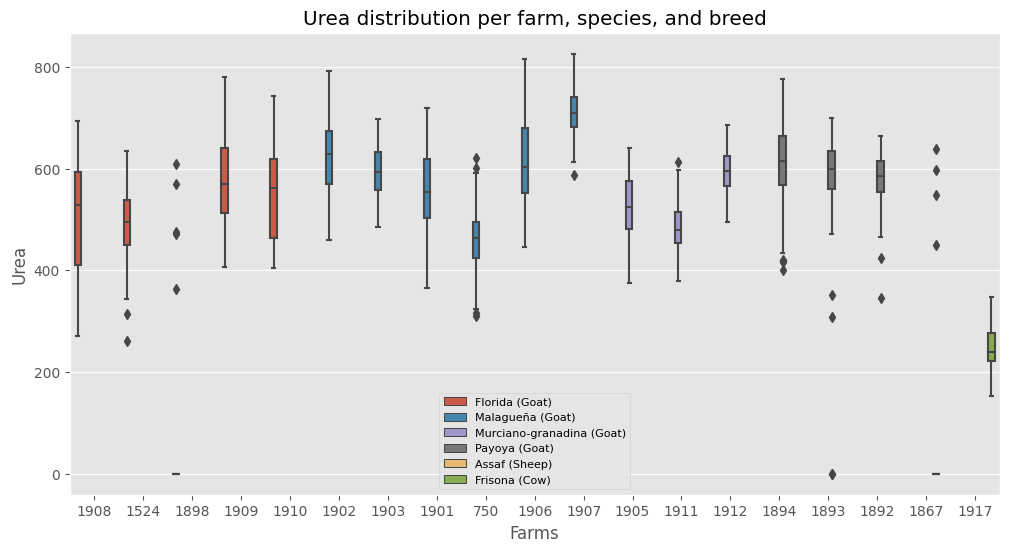

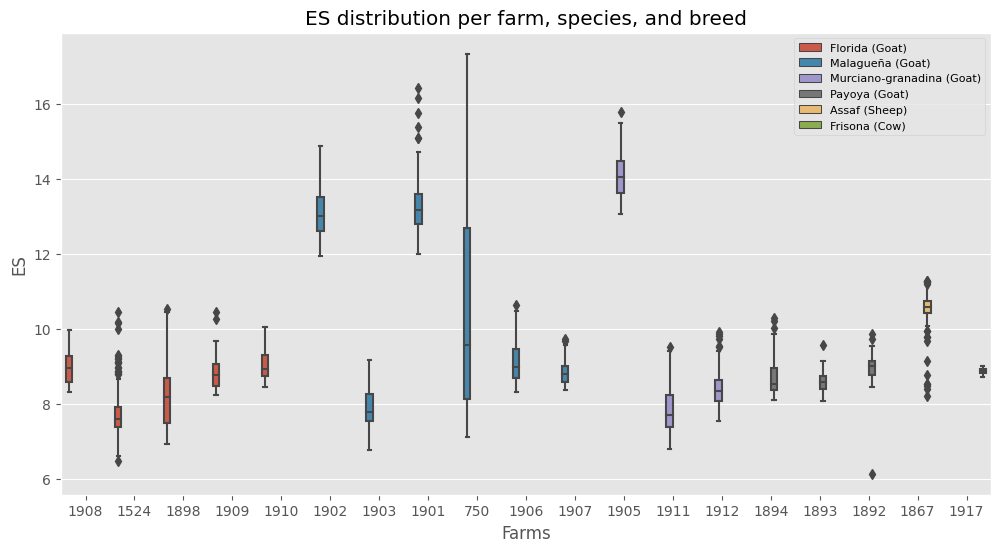

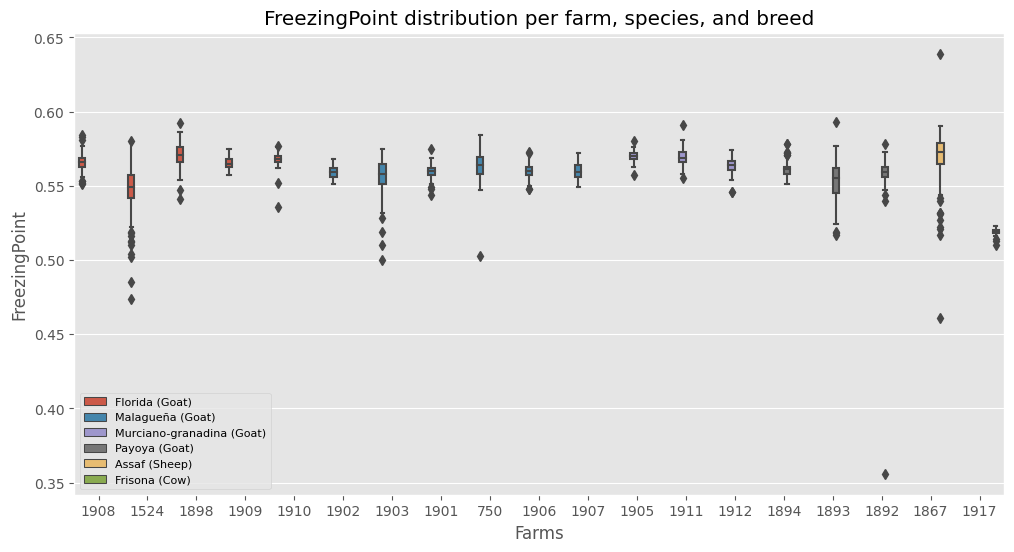

In [16]:
# Plot measurements' distributions per farm, and animal species and breed
images_subfolder = Path("1 - Measurement distributions per farm, species, and breed")
for _, (MeasurementTypeId, Measurement) in MeasurementType.iterrows():
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(x="ManagementAreaId", y=Measurement, hue="Breed", data=MilkMeasurements)
    ax.set_xlabel("Farms")
    title = f"{Measurement} distribution per farm, species, and breed"
    ax.set_title(title)
    ax.legend(fontsize=8)
    plt.savefig(images / images_subfolder / f"{title}.png")
    plt.show()

# Measurement trigger values per farm

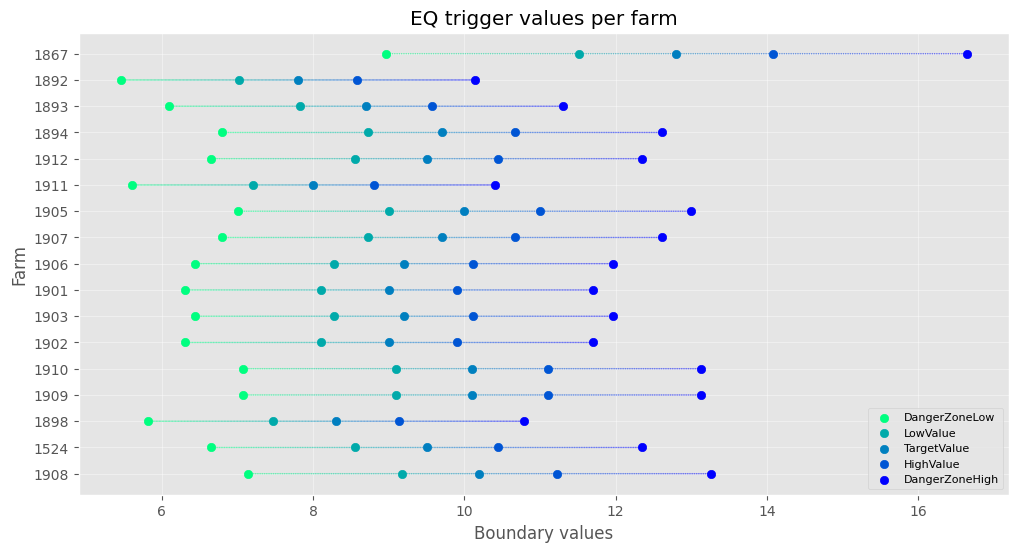

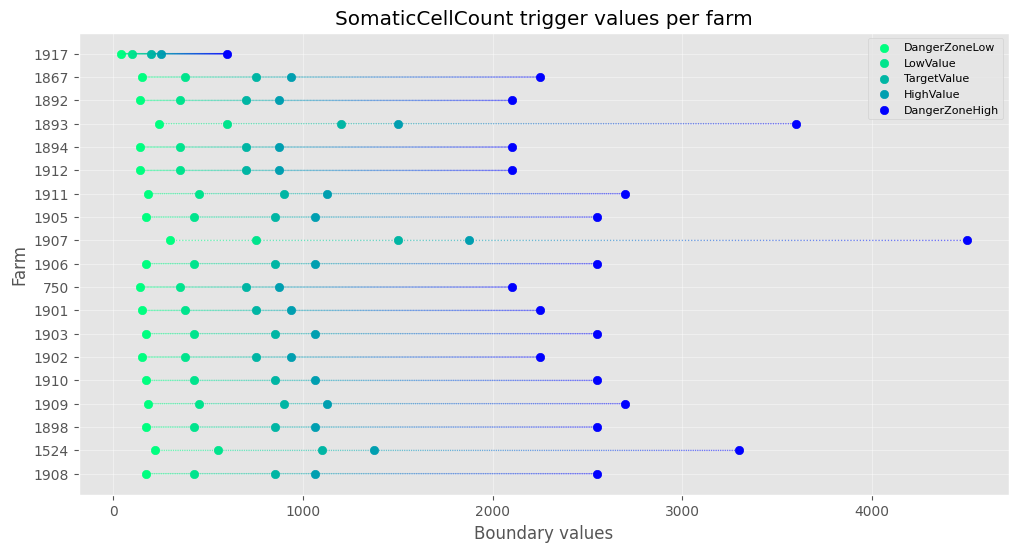

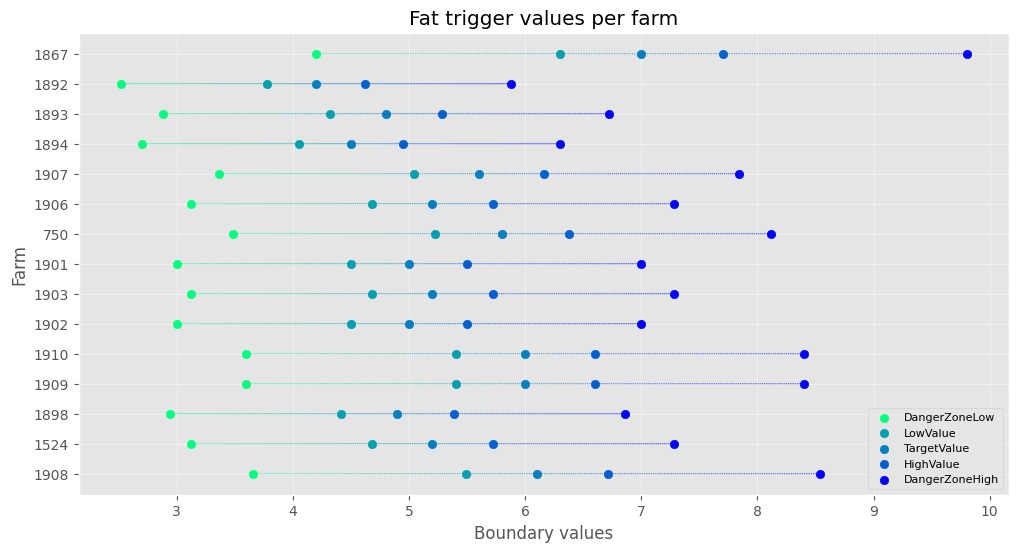

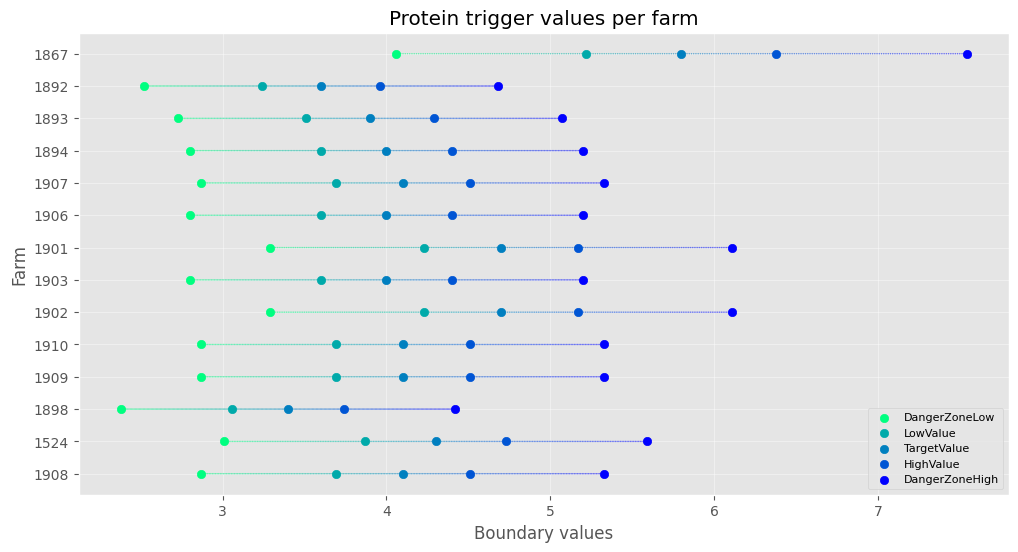

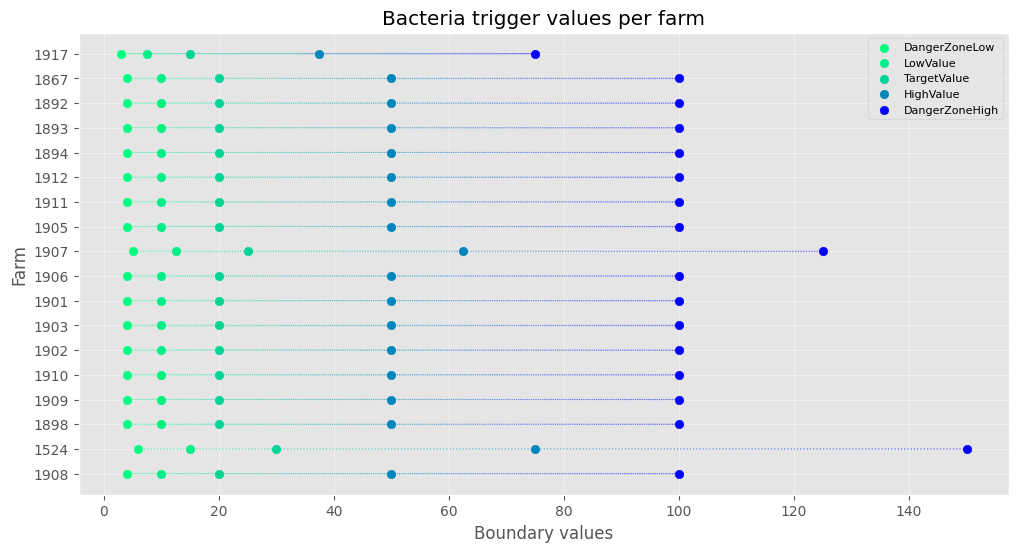

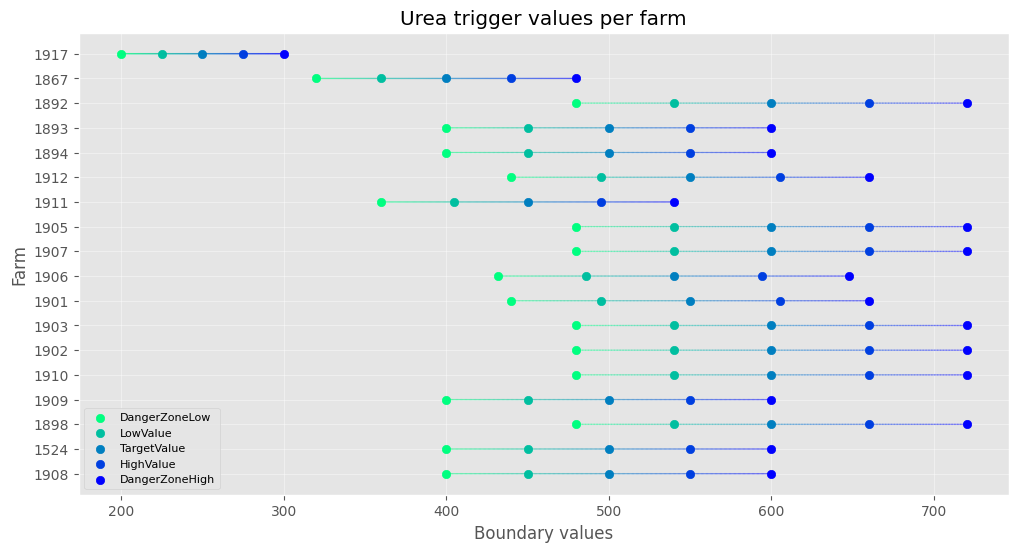

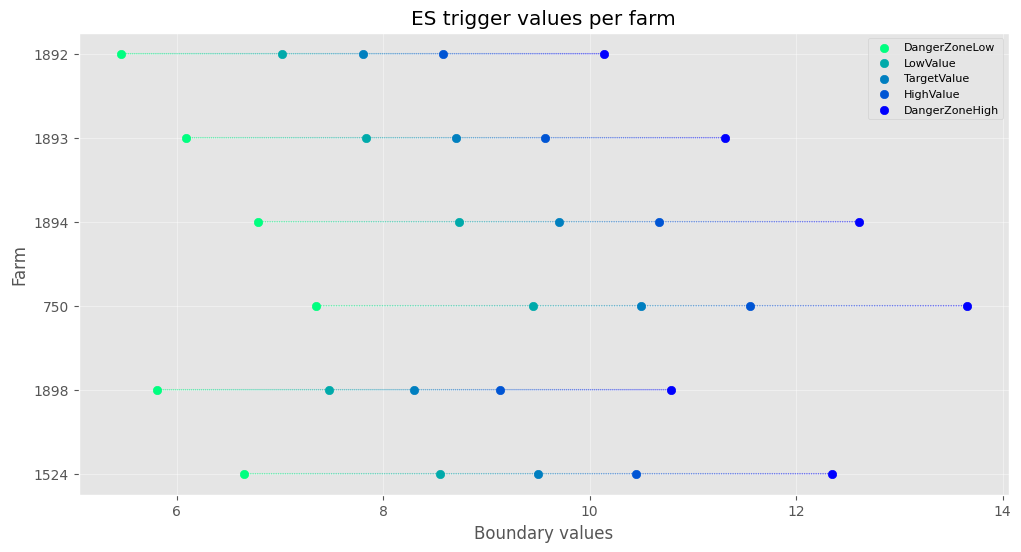

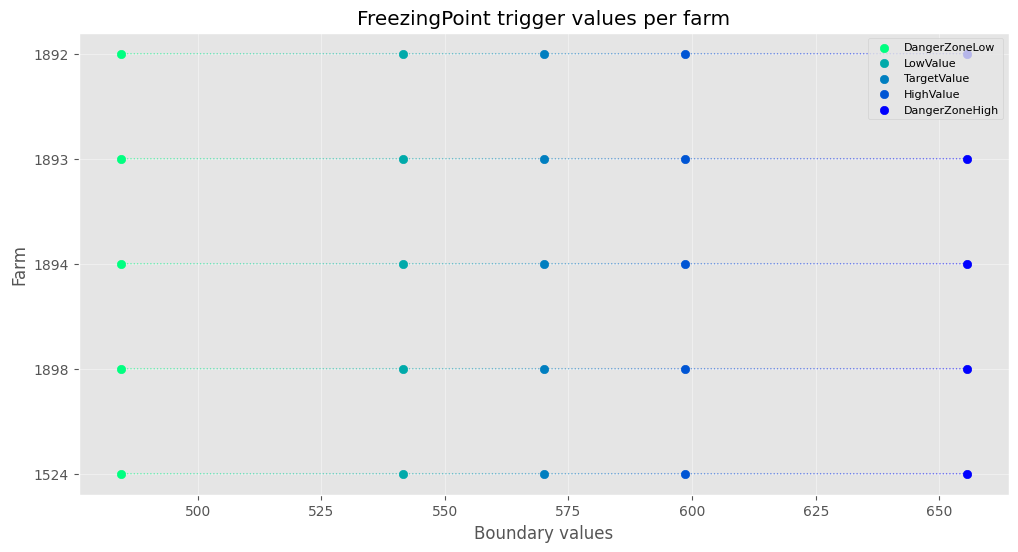

In [17]:
# Measurement ranges for known farms only
MeasurementRange = (
    MilkMeasurements[["ManagementAreaId"]]
    .drop_duplicates()
    .merge(MeasurementRange, on="ManagementAreaId")
)

# Columns containing the intervals bounding for each farm
boundary_columns = [
    "DangerZoneLow",
    "LowValue",
    "TargetValue",
    "HighValue",
    "DangerZoneHigh",
]

# Plot colormap
cmap = plt.get_cmap("winter_r")

# Save folder
images_subfolder = Path("2 - Measurement trigger values per farm")

# Iterate over each milk characteristic
for _, (MeasurementTypeId, Measurement) in MeasurementType.iterrows():
    fig, ax = plt.subplots(figsize=(12, 6))

    # Data for a specific milk measurement
    MeasurementRangeData = MeasurementRange[
        MeasurementRange["MeasurementTypeId"] == MeasurementTypeId
    ][["ManagementAreaId"] + boundary_columns]

    # Iterate over each farm
    for i, (_, row) in enumerate(MeasurementRangeData.iterrows()):
        # Get the farm
        ManagementAreaId = row["ManagementAreaId"]

        # Get the boundary values
        boundary_values = row[boundary_columns].values

        # Normalize the values to range [0, 1] for colormap
        norm_values = (boundary_values - boundary_values.min()) / (
            boundary_values.max() - boundary_values.min()
        )

        # Get the colors for each point
        point_colors = [cmap(norm) for norm in norm_values]

        # Iterate over each boundary value
        for j, value in enumerate(boundary_values):
            if i == 0:  # add legend once
                ax.scatter(
                    value,
                    ManagementAreaId,
                    color=point_colors[j],
                    label=boundary_columns[j],
                )
            else:
                ax.scatter(value, ManagementAreaId, color=point_colors[j])

        # Plot a line connecting the points with gradient colors
        line_x = np.linspace(boundary_values[0], boundary_values[-1], 256)
        line_y = [ManagementAreaId] * 256
        line_colors = [cmap(i) for i in range(256)]
        ax.scatter(line_x, line_y, color=line_colors, s=0.4, alpha=0.4)

    # Labels, title, grid and legend
    ax.set_xlabel("Boundary values")
    ax.set_ylabel("Farm")
    title = f"{Measurement} trigger values per farm"
    ax.set_title(title)
    ax.grid(True, alpha=0.4)
    ax.legend(fontsize=8)

    # Save and display the plot
    plt.savefig(images / images_subfolder / f"{title}.png")
    plt.show()

# Distribution of trigger values per farm

In [18]:
# Load saved (melted) data
MeltedMilkMeasurements = pd.read_csv(output / "MeltedMilkMeasurements.csv")
MeltedMilkMeasurements.head()

,Id,ManagementAreaId,MeasurementTypeId,Measurement,Value,Rank,TriggerValue
0,1401,750,3,SomaticCellCount,1273.00,9,High
1,1401,750,4,Fat,4.47,7,Low
2,1401,750,8,ES,8.28,8,Low
3,1402,750,3,SomaticCellCount,1288.00,9,High
4,1402,750,4,Fat,4.66,7,Low


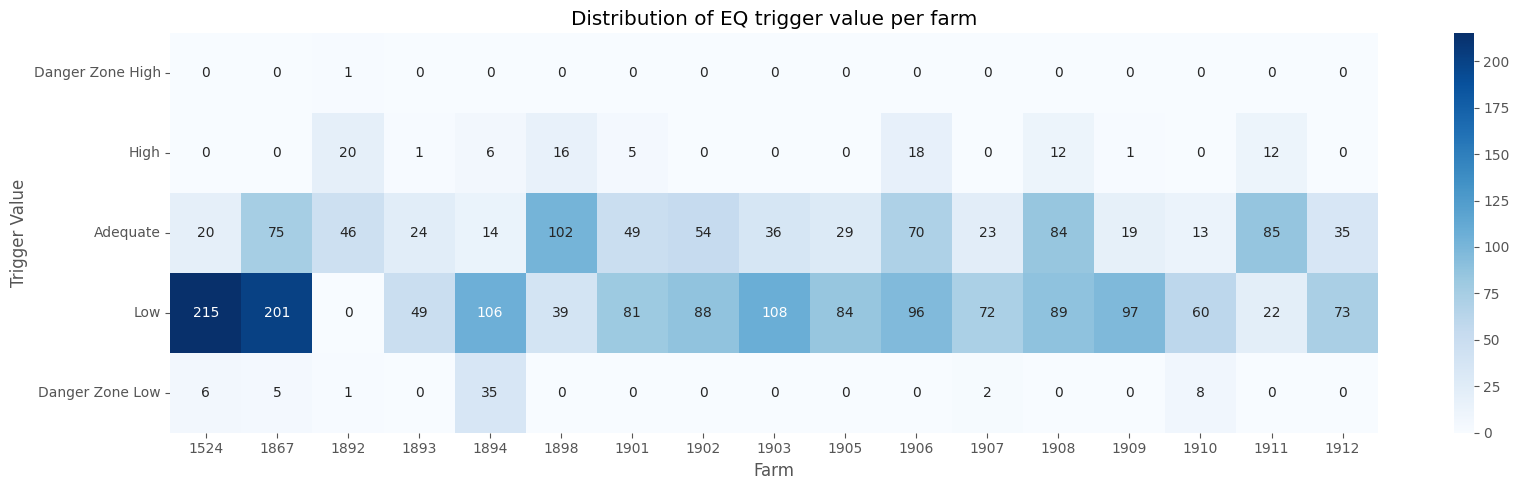

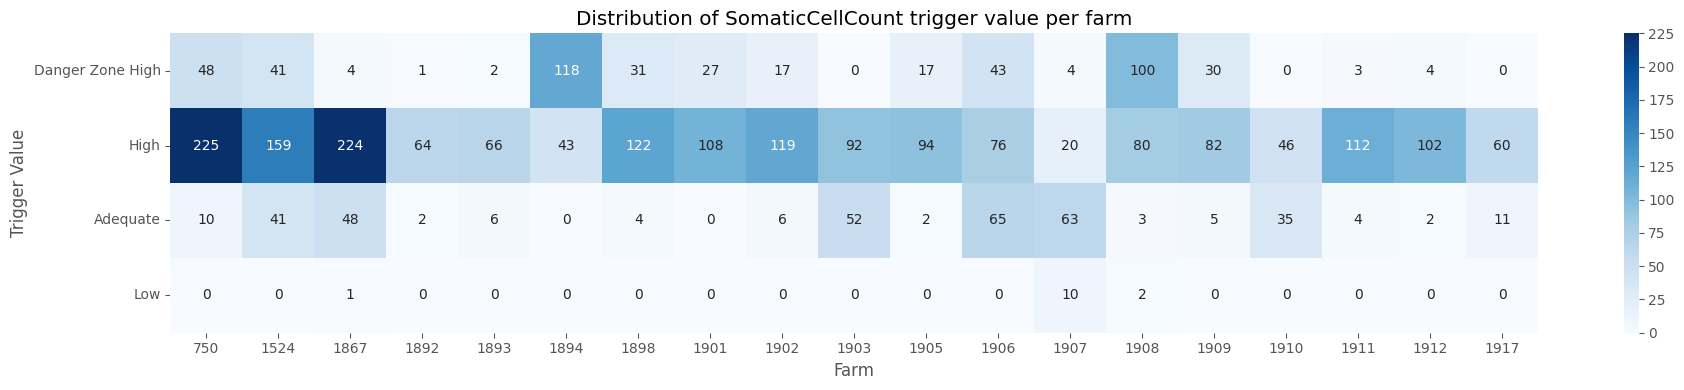

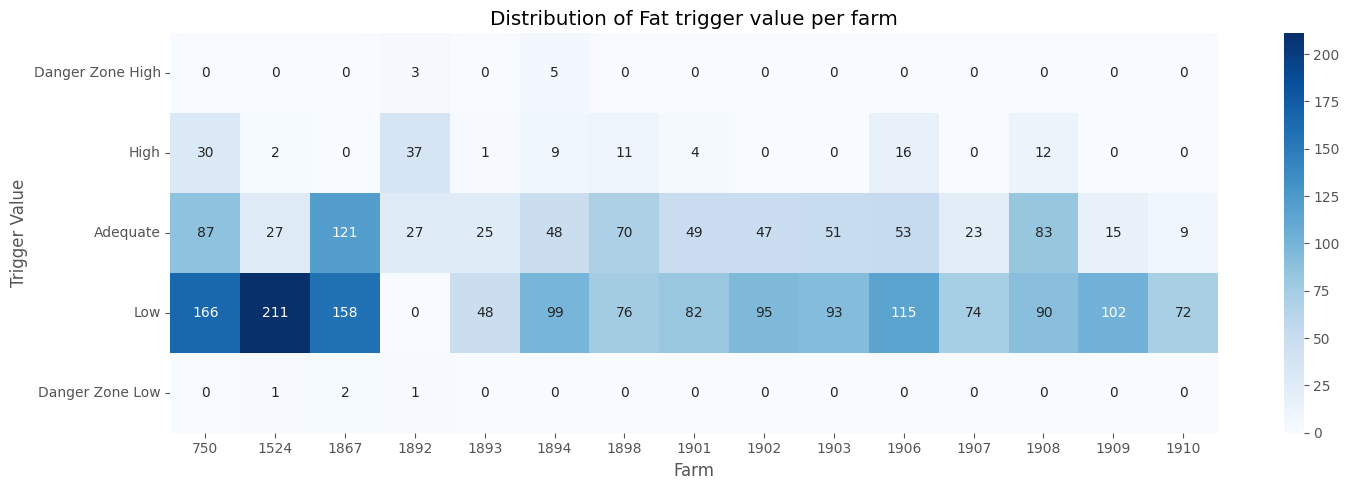

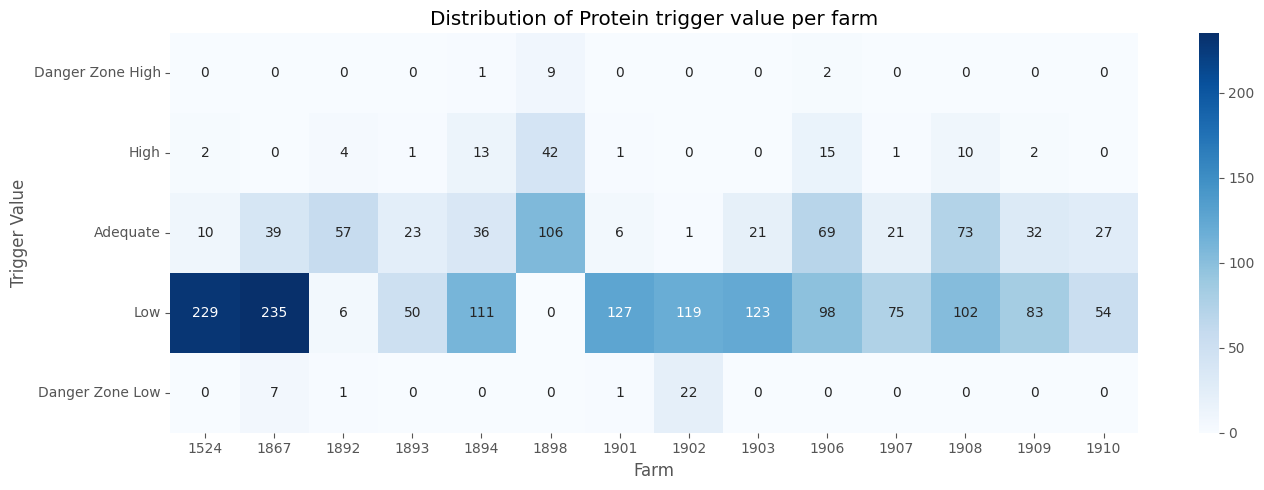

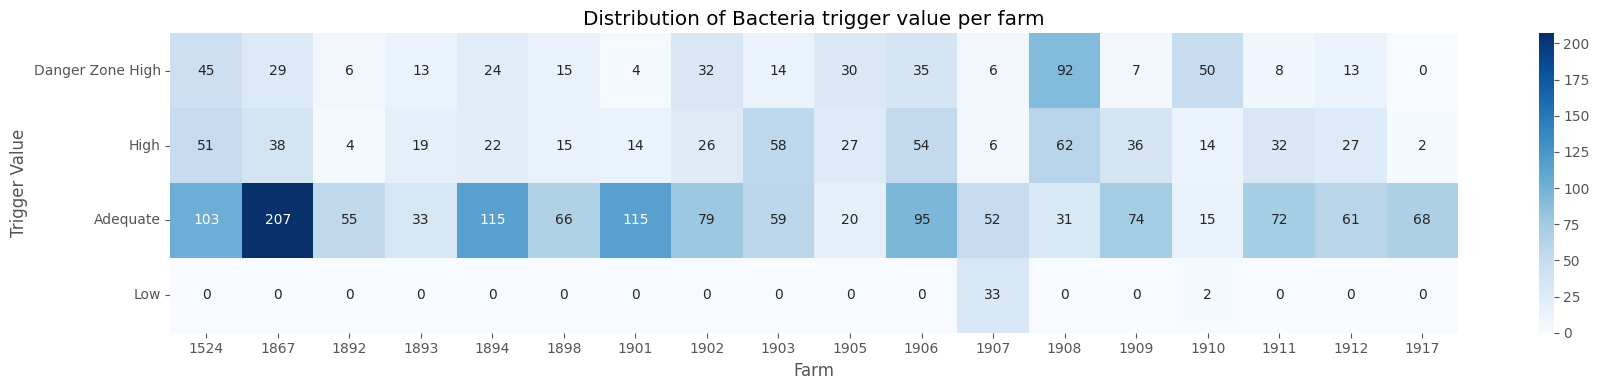

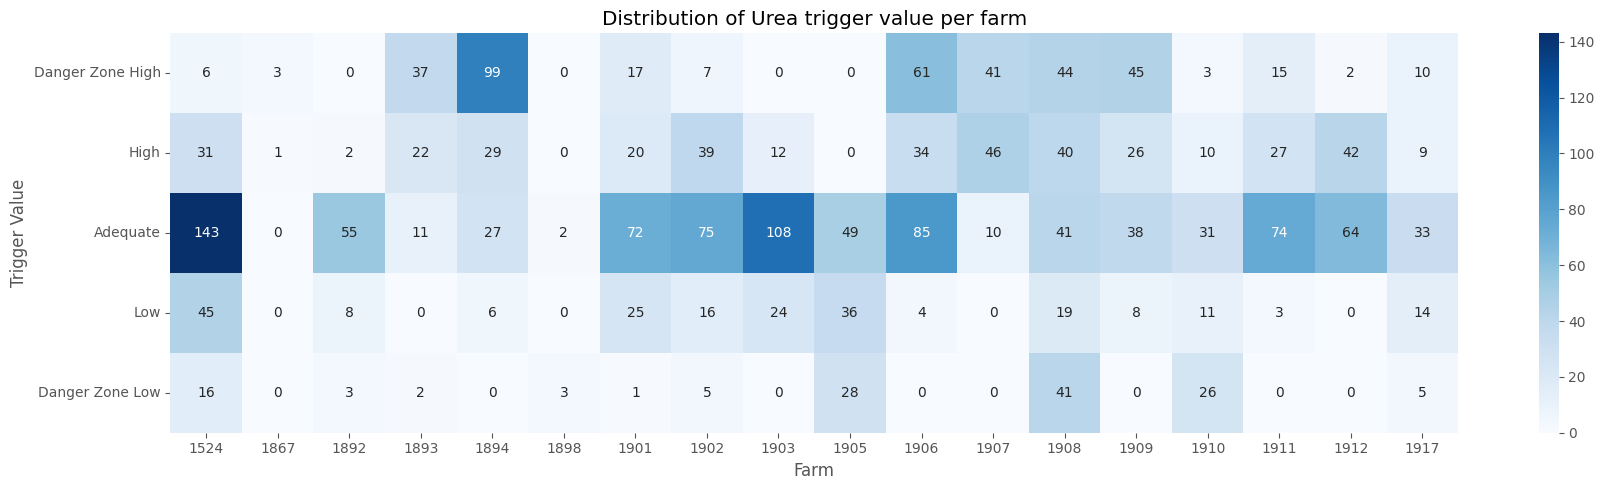

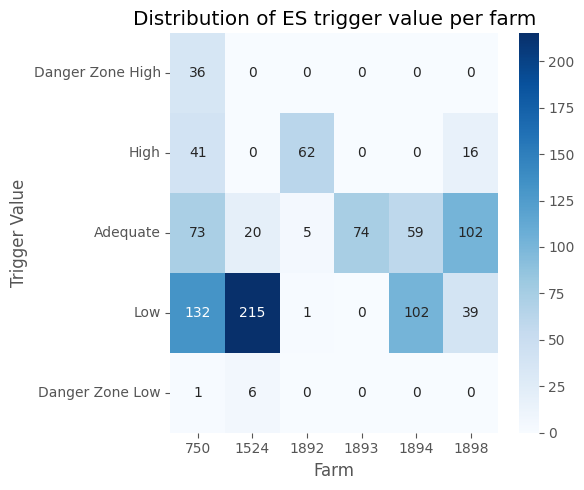

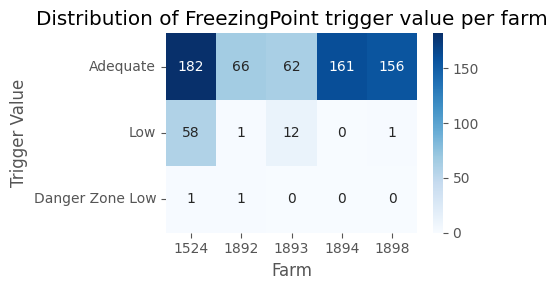

In [19]:
# Dictionary to correctly sort the data
boundaries_order = {
    value: index
    for index, value in enumerate(
        ["Danger Zone High", "High", "Adequate", "Low", "Danger Zone Low"]
    )
}

# Save folder
images_subfolder = Path("3 - Distribution of trigger values per farm")

# Iterate over each milk characteristic
for _, (_, Measurement) in MeasurementType.iterrows():
    # Count data points per farm and trigger value
    MeasurementDistributionPerFarm = (
        MeltedMilkMeasurements[MeltedMilkMeasurements["Measurement"] == Measurement]
        .groupby(["ManagementAreaId", "TriggerValue"])
        .size()
        .reset_index(name="Count")
        .pivot(index="TriggerValue", columns="ManagementAreaId", values="Count")
        .fillna(0)
    )

    # Order the resulting data
    new_index_order = sorted(
        MeasurementDistributionPerFarm.index,
        key=lambda item: boundaries_order.get(item),
    )
    MeasurementDistributionPerFarm = MeasurementDistributionPerFarm.reindex(
        new_index_order
    )

    # Plot the count matrix
    plt.figure(figsize=MeasurementDistributionPerFarm.shape[::-1])
    sns.heatmap(MeasurementDistributionPerFarm, annot=True, fmt="g", cmap="Blues")

    # Title, ticks, labels, save and display
    title = f"Distribution of {Measurement} trigger value per farm"
    plt.title(title)
    plt.xlabel("Farm")
    plt.xticks(rotation=0)
    plt.ylabel("Trigger Value")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(images / images_subfolder / f"{title}.png")
    plt.show()